##Know Your Mushrooms 

In the US alone, around 7500 yearly cases of mushroom poisoning are reported (Source). According to the source, "misidentification of edible mushroom species appears to be the most common cause and may be preventable through education". 

To avoid expenses for hospitalization and in some cases pointless deaths, you have been hired by US National Health Service to create a machine-learning model, that can recognize mushroom types. They want to install this on hand-held devices and to help people make the right choice when mushroom picking.

In [3]:
!pip install fastbook
import fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [4]:
from fastbook import *
from fastai.vision.widgets import *

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/Mushrooms'

Mounted at /content/drive


In [7]:
import cv2
from tqdm import tqdm

In [8]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**The data**

The datafile we are working on today is 2GB of mushroom images. There is a huge file called 'Mushrooms', with folders within it representing 8 mushroom classes.

In [9]:
fns = get_image_files(path)
fns

(#13428) [Path('/content/drive/My Drive/Mushrooms/Hygrocybe/072_G-fOGmTh3jY.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/010_VVjiGvYb6yM.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/029_SZIbojUxXyM.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/092_pLnT-Cgm2OA.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/054_h1dqNB3niA0.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/043_RM18aprRsvU.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/099_BDIBlqciLNc.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/079_xVMQ3LbF-DA.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/110_QzQqyA3INWI.jpg'),Path('/content/drive/My Drive/Mushrooms/Hygrocybe/027_58yTWJ00RKo.jpg')...]

In [ ]:
#failed = verify_images(fns)
#failed

In [ ]:
#failed.map(Path.unlink);

I commented on this code, as the notebook was running multiple times and during our first run, we learn that all images are OK. 

**EDA**
Let's learn about distribution of classes in our dataset.

In [ ]:
labels = ['Suillus', 'Russula','Agaricus', 'Boletus', 'Amanita', 'Lactarius', 'Hygrocybe', 'Entoloma', 'Cortinarius' ]
IMG_SIZE = 124

In [ ]:
def loadData(DIR):
    X = []
    Y = []
    for label in labels:
        path = os.path.join(DIR, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(arr, (IMG_SIZE, IMG_SIZE))
                X.append(resized_arr)
                Y.append(class_num)
            except Exception as e:
                print(e)
    return (np.array(X), np.array(Y))

In [ ]:
(X, Y) = loadData(path)

100%|██████████| 836/836 [00:21<00:00, 39.41it/s]


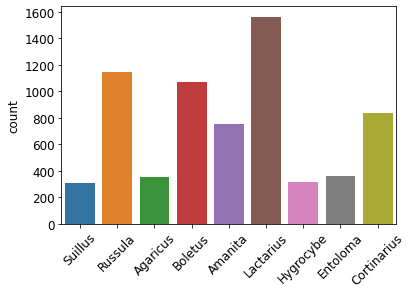

In [ ]:
l = []
for img in Y:
    l.append(labels[img])

plt.xticks(rotation=45)
sns.countplot(l)
plt.show()


It is clear that we are dealing with an imbalanced dataset (Hygrocybe sample is 5 times smaller than Lactarius sample), and this will be a multi-categorical problem. 

**Preparing the dataset**

Using RandomSplitter to split the data into training and validation datasets

In [10]:
mushrooms = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label
)

Resizing all the images with the RandomResizedCrop() to 224 and aug_transforms() for data augmentation.

In [11]:
mushrooms = mushrooms.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

Now the DataBlock is ready, we can create DataLoader

In [12]:
dls = mushrooms.dataloaders(path)

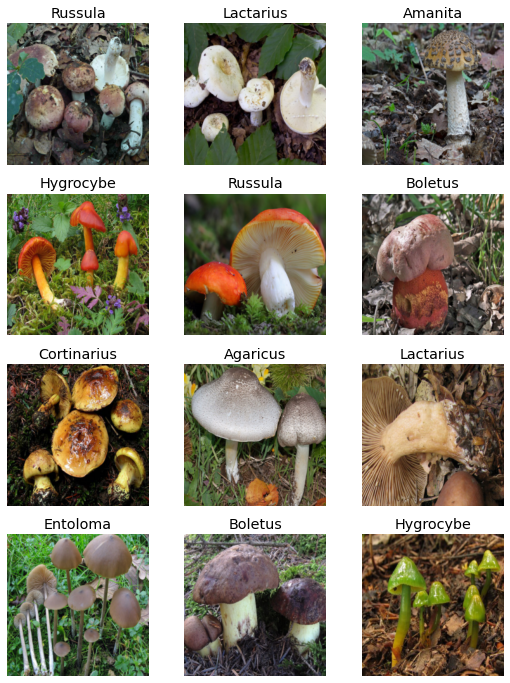

In [13]:
dls.valid.show_batch(max_n=12, nrows=4) 

**Creating the model**

We will be using pretrained model RESNET - Residual Network is a deep learning model used for computer vision applications. It is a Convolutional Neural Network (CNN) architecture designed to support hundreds or thousands of convolutional layers.

It already contains a set of filters (or kernels), the parameters of which are to be learned throughout the training. 

Number 50 means that it is a convolutional neural network that is 50 layers deep.

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pt

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575)

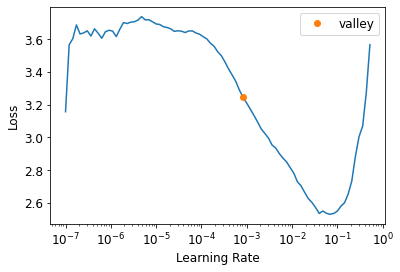

In [14]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.lr_find()

**fine_tune** initially freezes pretrained model weights and trains using **fit_one_cycle** with one epoch to enable random weights in head to adjust to new dataset. After unfreeze entire network will be trained with same fit_one_cycle method with choosen no of epochs.

In [16]:
learn.fine_tune(10, 0.0008)

epoch,train_loss,valid_loss,error_rate,time
0,1.319317,0.777570,0.246183,21:20


epoch,train_loss,valid_loss,error_rate,time
0,0.768979,0.475625,0.157542,03:42
1,0.541243,0.323577,0.110987,03:40
2,0.344894,0.214237,0.070763,03:43
3,0.220496,0.164779,0.046927,03:42
4,0.149860,0.137848,0.043948,03:40
5,0.101445,0.100152,0.026071,03:42
6,0.074615,0.092894,0.024209,03:41
7,0.057014,0.075909,0.022719,03:41
8,0.041606,0.076232,0.021974,03:41
9,0.042079,0.077693,0.023464,03:42


After 8th epoch our model showed higher error rate. The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data. As training loss became much lower than validation loss, in the end we overfitted the model. 

**Analysing the results**

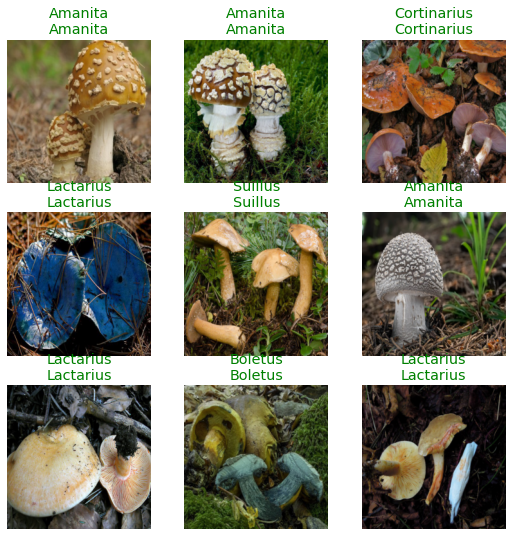

In [17]:
learn.show_results()

confusion matrix

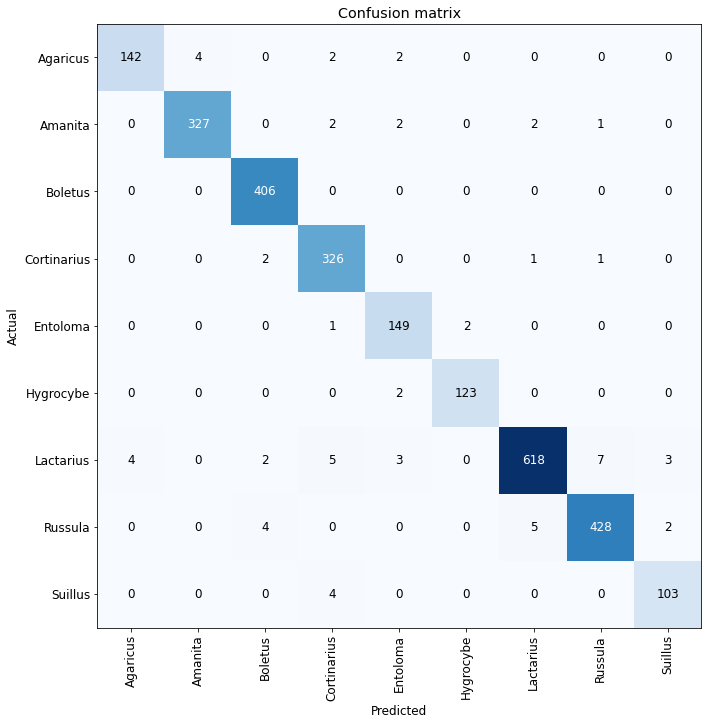

In [18]:
from IPython.core.pylabtools import figsize 
interp = ClassificationInterpretation.from_learner(learn) 
interp.plot_confusion_matrix(figsize=(10,10))

By visualizing our results we can see that we created a trustworthy model. Looking at category Lactarius only, we guessed right 618 times out of 642, which makes it believe we will be **96 percent** of times accurate.

**Looking for the improvements**

plot_top_losses is a functionality, which allows users to inspect models' results by plotting images sorted by various combinations of losses.

This API makes it easy to immediately spot pictures the model struggles the most with, giving the practitioner the opportunity to take swift action to correct this behaviour (remove wrong samples, correct mis-labellings, etc)

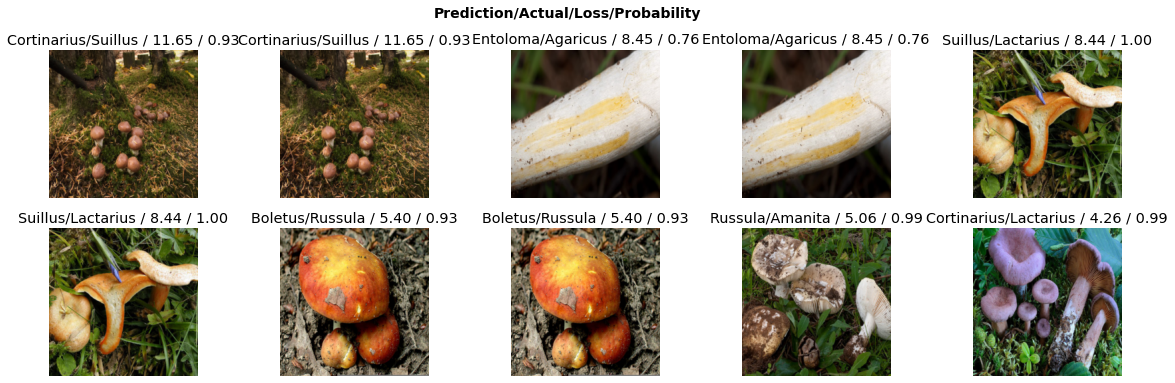

In [19]:
interp.plot_top_losses(10, nrows=2, figsize=(20,6))

By seeing these images and probabilities, I can understand what was the most difficult for my model. For example, Suillus mushroom category was problematic and we could definitely start improving our model from here. 

As we remember, Suillus was the category with the least pictures, so we can definitely try to get more images of this mushroom and that will definitely increase our accuracy. 

**Saving the model**

In [20]:
learn.export(fname='resnet50.pkl')

##Summary

*  We were able to build a trustworthy Neural Network model with FastAI
*  We discovered problematic areas, such as struggles in recognizing Suillus mushroom class.
*  Restnet (CNN) supported our project well - we started the project with an error rate 0.245.
